# Instructions

Draw on everything we've discussed to build and train a model to get the best performance on CIFAR that you can. Tentatively due on the 10th. Ideally you can set this up to run fairly easily using the code that you've developed so far, and can let that churn while you focus on your final project.

(Somewhat open ended question - there is no 'right' answer here, but I am looking for some amount of thoroughness/breadth of your approach and discussion of your approach. One thing that I'll note here, it might be worth thinking about how you could experiment with different models to find a good one before launching a 'full' training run.)

# Response

I used various network architectures and training strategies to solve the CIFAR-10 classification problem. At first, I tried a basic convolutional neural network and it yielded moderate accuracy. I used multiple convolutional layers, followed by batch normalization, ReLU activations, and max pooling. I trained with Cross Entropy Loss and Adam optimizer. This initially gave me significant overfitting so I added dropout layers, weight decay, and data augmentation to improve generalization. in 60 epochs, I achieved around 84% accuracy, with minor overfitting. 

To improve test accuracy, I then tried a residual convolutional network architecture. This made sense as it allowed for deeper networks while avoiding the vanishing gradient problem. Passing in the input through residual blocks would help the model learn identity mappings and improve training. I started by making a residual block with 2 convolutional layers, each followed by a batch normalization and a ReLU activation. There is a skip connection which lets the input bypass the convolutional layers and be added directly to the output of the second convolutional layer. I then used multiple of these residual blocks in a custom ResNet. This started with an initial convolutional layer (with batch norm and ReLU) followed by 3 layers of residual layers, each with 2 residual blocks and an average pooling layer. I increased the number of filters in each layer (16, 32, 64) and finally used a fully connected layer to output class scores. I was able to get around 86% accuracy after training for 50 epochs but this network suffered from overfitting as well. 

Therefore, I tried adding a learning rate scheduler with CosineAnnealingLR to reduce the learning rate over time. Increasing the epochs to 60 and using a slightly higher learning rate of 0.003 with weight decay of 1e-3 helped improve the performance further. This got me to 88.81% accuracy on the test set. As loss had not converged yet, I trained again for 80 epochs and got 89.49% accuracy.

Now to increase the accuracy a little more, I tried increasing model capacity by creating a deeper residual network. For each residual layer, I added an additional residual block (3 blocks instead of 2). I trained this deeper network for 100 epochs with other same hyperparamters and achieved a final test accuracy of 90.72%. The table below shows the final loss and accuracy for this model, labeled as `deepresnet`. Its training dynamics are in the last graph in this notebook. 

| Model      | Final Train Loss | Final Test Loss | Final Test Accuracy |
|------------|------------------|-----------------|---------------------|
| deepresnet | 0.2403           | 0.2986          | 90.72%              |

CIFAR-10 has complex varied data points with texture, color, and small shapes. The CNN and simple ResNet architectures captured most of this but not all due to their limited depth. They could not capture the rich feature heirarchy. The extra residual block per layer in the deeper ResNet allowed for more nonlinear transformations and more filters at higher stages. The ResNet allowed gradients to cleanly propagate through the network and learn incremental refinements. 

# Code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

Using device: cuda


Load Data

In [67]:
# CIFAR-10 (32x32 RGB)
normalize = transforms.Normalize( mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010], )
# Add augmentation to the training transform
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(), 
    normalize
])
test_transform = transforms.Compose([transforms.ToTensor(), normalize])

cifar_train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
cifar_test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

cifar_train_loader = DataLoader(cifar_train_ds, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
cifar_test_loader  = DataLoader(cifar_test_ds,  batch_size=512, shuffle=False, num_workers=0, pin_memory=True)

Save network function

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)

def save_checkpoint(model, optimizer, path, scheduler=None, epoch=0):
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict() if scheduler is not None else None,
    }, path)

def load_checkpoint(model, path, optimizer=None, scheduler=None, device='cpu'):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    if optimizer is not None and checkpoint.get('optimizer_state') is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state'])
    if scheduler is not None and checkpoint.get('scheduler_state') is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        
    return checkpoint.get('epoch', 0)


## Models

In [69]:
class ConvNetwork(nn.Module):
    def __init__(self, input_size=(3, 32, 32), num_classes=10, device='cpu'):
        super().__init__()
        
        # Convolutional Layers
        conv_layers = []
        conv_layers.extend([
            # Block 1
            nn.Conv2d(input_size[0], 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),
        ])
        self.conv_layers = nn.Sequential(*conv_layers)

        # Get flattened size with dummy tensor
        with torch.no_grad():
            dummy = torch.zeros(1, *input_size)
            dummy_out = self.conv_layers(dummy)
            flattened_dim = dummy_out.view(1, -1).size(1)

        # Fully Connected Layers
        fc_layers = []
        fc_layers.extend([
            nn.Linear(flattened_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        ])
        self.fc_layers = nn.Sequential(*fc_layers)

        self.to(device)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [70]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device='cpu'):
        super().__init__()

        self.conv1 =nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_channels)
            )

        self.to(device)

    def forward(self, x):
        identity = self.downsample(x) if self.downsample else x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # Add skip connection
        x = self.relu(x + identity)
        return x
    
class ResidualConvNetwork(nn.Module):
    def __init__(self, input_size=(3, 32, 32), num_classes=10, device='cpu'):
        super().__init__()

        # Initial convolutional layer
        self.conv = nn.Conv2d(input_size[0], 16, kernel_size=3, padding='same')
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential(
            ResidualBlock(16, 16, device=device),
            ResidualBlock(16, 16, device=device),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            ResidualBlock(16, 32, device=device),
            ResidualBlock(32, 32, device=device),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            ResidualBlock(32, 64, device=device),
            ResidualBlock(64, 64, device=device),
        )

        # Fully connected layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, num_classes)

        self.to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
class DeepResidualConvNetwork(nn.Module):
    def __init__(self, input_size=(3, 32, 32), num_classes=10, device='cpu'):
        super().__init__()

        self.conv = nn.Conv2d(input_size[0], 16, kernel_size=3, padding='same')
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential(
            ResidualBlock(16, 16, device=device),
            ResidualBlock(16, 16, device=device),
            ResidualBlock(16, 16, device=device),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            ResidualBlock(16, 32, device=device),
            ResidualBlock(32, 32, device=device),
            ResidualBlock(32, 32, device=device),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            ResidualBlock(32, 64, device=device),
            ResidualBlock(64, 64, device=device),
            ResidualBlock(64, 64, device=device),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, num_classes)

        self.to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001, decay=0.0001, plot=False, device='cpu',
                start_epoch=0, checkpoint_path=None, save_checkpoint_path=None, resume=False):
    model.to(device)
    train_losses, test_losses = [], []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    
    # Scheduler covers the remaining epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    if resume and checkpoint_path is not None and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        loaded_epoch = load_checkpoint(model, checkpoint_path, optimizer, scheduler, device=device)
        start_epoch = loaded_epoch + 1
        # Fast-forward scheduler to correct step
        for _ in range(start_epoch):
            scheduler.step()

    print(f"Training from epoch {start_epoch+1} to {num_epochs}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_running_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = test_running_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        if save_checkpoint_path is not None:
            save_checkpoint(model, optimizer, save_checkpoint_path, scheduler, epoch)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(range(start_epoch + 1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(start_epoch + 1, num_epochs + 1), test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.show()

    return model, train_losses, test_losses

def test_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

## Testing Models

Epoch 1/60, Train Loss: 1.8664, Test Loss: 1.3874
Epoch 2/60, Train Loss: 1.5623, Test Loss: 1.2338
Epoch 3/60, Train Loss: 1.4394, Test Loss: 1.0935
Epoch 4/60, Train Loss: 1.3427, Test Loss: 1.0088
Epoch 5/60, Train Loss: 1.2767, Test Loss: 0.9465
Epoch 6/60, Train Loss: 1.2239, Test Loss: 0.8967
Epoch 7/60, Train Loss: 1.1840, Test Loss: 0.8815
Epoch 8/60, Train Loss: 1.1511, Test Loss: 0.8588
Epoch 9/60, Train Loss: 1.1230, Test Loss: 0.8232
Epoch 10/60, Train Loss: 1.0944, Test Loss: 0.7999
Epoch 11/60, Train Loss: 1.0598, Test Loss: 0.7941
Epoch 12/60, Train Loss: 1.0393, Test Loss: 0.7429
Epoch 13/60, Train Loss: 1.0201, Test Loss: 0.7398
Epoch 14/60, Train Loss: 1.0061, Test Loss: 0.7046
Epoch 15/60, Train Loss: 0.9881, Test Loss: 0.7253
Epoch 16/60, Train Loss: 0.9696, Test Loss: 0.6984
Epoch 17/60, Train Loss: 0.9584, Test Loss: 0.6848
Epoch 18/60, Train Loss: 0.9442, Test Loss: 0.6942
Epoch 19/60, Train Loss: 0.9316, Test Loss: 0.6606
Epoch 20/60, Train Loss: 0.9169, Test Lo

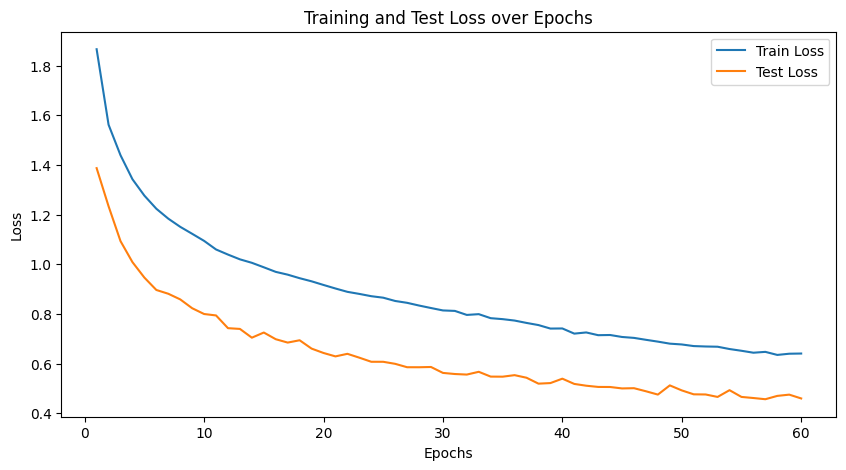

Final Test Accuracy: 84.09%


In [22]:
cnn = ConvNetwork(input_size=(3, 32, 32), device=device)
cnn, train_losses, test_losses = train_model(cnn, cifar_train_loader, cifar_test_loader, num_epochs=60, lr=0.0005, plot=True, device=device)
final_test_accuracy = test_model(cnn, cifar_test_loader, device=device)

print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Epoch 1/50, Train Loss: 1.5139, Test Loss: 1.3506
Epoch 2/50, Train Loss: 1.0390, Test Loss: 1.0709
Epoch 3/50, Train Loss: 0.8508, Test Loss: 0.9638
Epoch 4/50, Train Loss: 0.7474, Test Loss: 0.8873
Epoch 5/50, Train Loss: 0.6744, Test Loss: 0.6766
Epoch 6/50, Train Loss: 0.6203, Test Loss: 0.7001
Epoch 7/50, Train Loss: 0.5725, Test Loss: 0.7180
Epoch 8/50, Train Loss: 0.5453, Test Loss: 0.5950
Epoch 9/50, Train Loss: 0.5099, Test Loss: 0.5786
Epoch 10/50, Train Loss: 0.4865, Test Loss: 0.6058
Epoch 11/50, Train Loss: 0.4564, Test Loss: 0.6417
Epoch 12/50, Train Loss: 0.4433, Test Loss: 0.5117
Epoch 13/50, Train Loss: 0.4352, Test Loss: 0.6338
Epoch 14/50, Train Loss: 0.4176, Test Loss: 0.4759
Epoch 15/50, Train Loss: 0.3903, Test Loss: 0.5535
Epoch 16/50, Train Loss: 0.3802, Test Loss: 0.5641
Epoch 17/50, Train Loss: 0.3700, Test Loss: 0.5450
Epoch 18/50, Train Loss: 0.3638, Test Loss: 0.5950
Epoch 19/50, Train Loss: 0.3462, Test Loss: 0.4772
Epoch 20/50, Train Loss: 0.3408, Test Lo

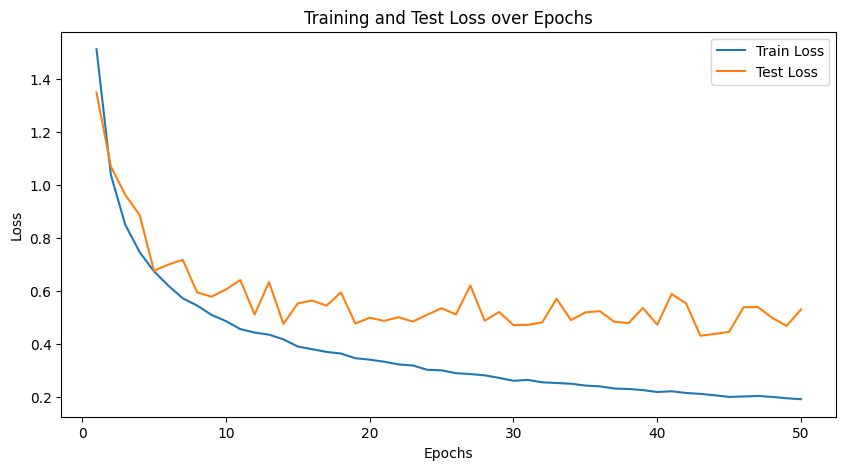

Final Residual Test Accuracy: 85.59%


In [ ]:
rescnn = ResidualConvNetwork(input_size=(3, 32, 32), device=device)
rescnn, res_train_losses, res_test_losses = train_model(rescnn, cifar_train_loader, cifar_test_loader, num_epochs=50, lr=0.001, plot=True, device=device)
final_res_test_accuracy = test_model(rescnn, cifar_test_loader, device=device)
save_model(rescnn, "rescnn1.pth")
print(f"Final Residual Test Accuracy: {final_res_test_accuracy:.2f}%")

Epoch 1/60, Train Loss: 1.6194, Test Loss: 1.6435
Epoch 2/60, Train Loss: 1.2420, Test Loss: 1.4224
Epoch 3/60, Train Loss: 1.0907, Test Loss: 1.0823
Epoch 4/60, Train Loss: 0.9971, Test Loss: 1.1400
Epoch 5/60, Train Loss: 0.9109, Test Loss: 0.9550
Epoch 6/60, Train Loss: 0.8479, Test Loss: 0.8704
Epoch 7/60, Train Loss: 0.8024, Test Loss: 1.2624
Epoch 8/60, Train Loss: 0.7754, Test Loss: 1.0513
Epoch 9/60, Train Loss: 0.7509, Test Loss: 0.7675
Epoch 10/60, Train Loss: 0.7241, Test Loss: 0.7028
Epoch 11/60, Train Loss: 0.7104, Test Loss: 0.8453
Epoch 12/60, Train Loss: 0.6929, Test Loss: 0.7226
Epoch 13/60, Train Loss: 0.6761, Test Loss: 1.3810
Epoch 14/60, Train Loss: 0.6771, Test Loss: 0.6610
Epoch 15/60, Train Loss: 0.6558, Test Loss: 0.7692
Epoch 16/60, Train Loss: 0.6450, Test Loss: 0.7207
Epoch 17/60, Train Loss: 0.6387, Test Loss: 0.7578
Epoch 18/60, Train Loss: 0.6301, Test Loss: 0.7060
Epoch 19/60, Train Loss: 0.6157, Test Loss: 0.8045
Epoch 20/60, Train Loss: 0.6102, Test Lo

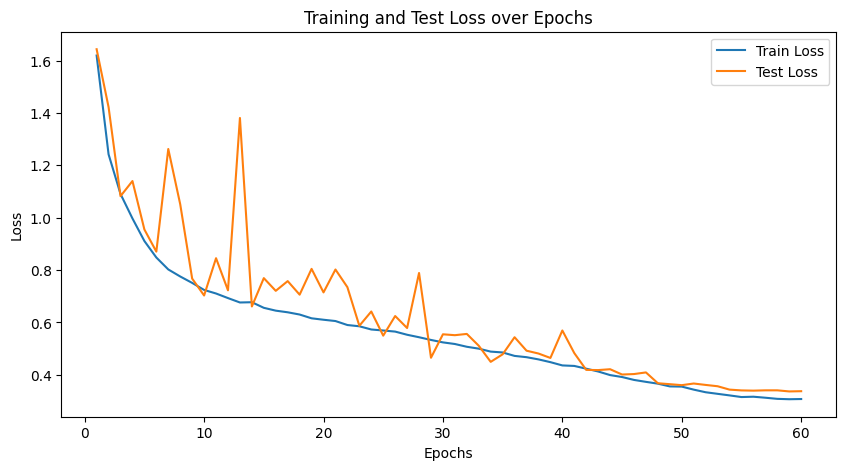

Final Residual Test Accuracy: 88.81%


In [ ]:
rescnn2 = ResidualConvNetwork(input_size=(3, 32, 32), device=device)
rescnn2, res2_train_losses, res2_test_losses = train_model(rescnn2, cifar_train_loader, cifar_test_loader, num_epochs=60, lr=0.003, decay=1e-3, plot=True, device=device)
final_res2_test_accuracy = test_model(rescnn2, cifar_test_loader, device=device)
save_model(rescnn2, "rescnn2.pth")
print(f"Final Test Accuracy: {final_res2_test_accuracy:.2f}%")

Training from epoch 1 to 80
Epoch 1/80, Train Loss: 1.6604, Test Loss: 1.4375
Epoch 2/80, Train Loss: 1.2482, Test Loss: 1.1574
Epoch 3/80, Train Loss: 1.0853, Test Loss: 1.1998
Epoch 4/80, Train Loss: 0.9718, Test Loss: 1.0478
Epoch 5/80, Train Loss: 0.8931, Test Loss: 0.9196
Epoch 6/80, Train Loss: 0.8436, Test Loss: 0.9856
Epoch 7/80, Train Loss: 0.8008, Test Loss: 1.3018
Epoch 8/80, Train Loss: 0.7776, Test Loss: 1.3525
Epoch 9/80, Train Loss: 0.7563, Test Loss: 0.7332
Epoch 10/80, Train Loss: 0.7251, Test Loss: 0.7706
Epoch 11/80, Train Loss: 0.7113, Test Loss: 0.7459
Epoch 12/80, Train Loss: 0.7064, Test Loss: 0.7628
Epoch 13/80, Train Loss: 0.6943, Test Loss: 0.9095
Epoch 14/80, Train Loss: 0.6728, Test Loss: 0.8499
Epoch 15/80, Train Loss: 0.6681, Test Loss: 0.7410
Epoch 16/80, Train Loss: 0.6602, Test Loss: 0.7191
Epoch 17/80, Train Loss: 0.6489, Test Loss: 0.6558
Epoch 18/80, Train Loss: 0.6382, Test Loss: 0.6439
Epoch 19/80, Train Loss: 0.6337, Test Loss: 0.6676
Epoch 20/80,

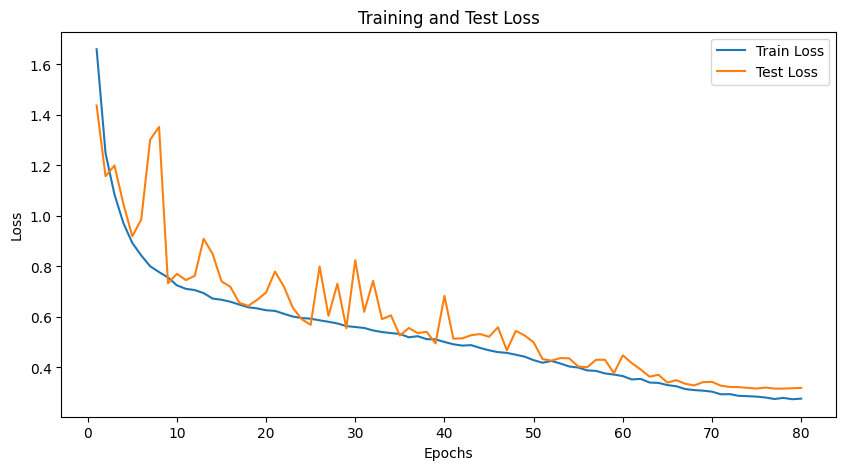

Final Test Accuracy: 89.49%


In [63]:
rescnn3 = ResidualConvNetwork(input_size=(3, 32, 32), device=device)
rescnn3, res3_train_losses, res3_test_losses = train_model(rescnn3, cifar_train_loader, cifar_test_loader, num_epochs=80, lr=0.003, decay=1e-3, plot=True, device=device,
                                                           save_checkpoint_path="checkpoints/rescnn3_ckpt.pth")
final_res3_test_accuracy = test_model(rescnn3, cifar_test_loader, device=device)
print(f"Final Test Accuracy: {final_res3_test_accuracy:.2f}%")

Starting Fine-tuning...
Resuming from checkpoint: checkpoints/rescnn3_ckpt.pth
Training from epoch 81 to 100
Epoch 81/100, Train Loss: 0.5968, Test Loss: 0.8388
Epoch 82/100, Train Loss: 0.5521, Test Loss: 0.6025
Epoch 83/100, Train Loss: 0.5370, Test Loss: 0.6938
Epoch 84/100, Train Loss: 0.5361, Test Loss: 0.7481
Epoch 85/100, Train Loss: 0.5350, Test Loss: 0.5624
Epoch 86/100, Train Loss: 0.5332, Test Loss: 0.7001
Epoch 87/100, Train Loss: 0.5349, Test Loss: 1.0914
Epoch 88/100, Train Loss: 0.5371, Test Loss: 0.6019
Epoch 89/100, Train Loss: 0.5382, Test Loss: 0.7414
Epoch 90/100, Train Loss: 0.5390, Test Loss: 0.7292
Epoch 91/100, Train Loss: 0.5326, Test Loss: 0.5775
Epoch 92/100, Train Loss: 0.5394, Test Loss: 0.5075
Epoch 93/100, Train Loss: 0.5340, Test Loss: 0.6727
Epoch 94/100, Train Loss: 0.5344, Test Loss: 0.6814
Epoch 95/100, Train Loss: 0.5434, Test Loss: 0.6917
Epoch 96/100, Train Loss: 0.5331, Test Loss: 0.6955
Epoch 97/100, Train Loss: 0.5375, Test Loss: 0.5368
Epoch 9

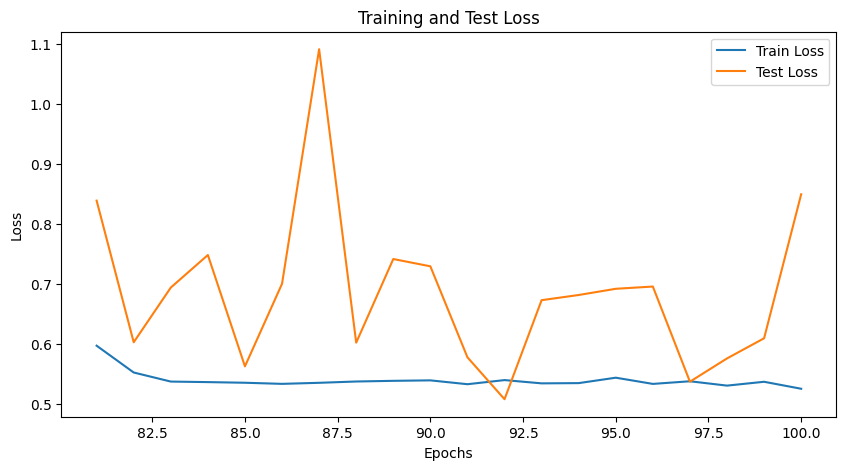

Final Fine-tuned Test Accuracy: 72.37%


In [64]:
print("Starting Fine-tuning...")
rescnn3 = ResidualConvNetwork(input_size=(3, 32, 32), device=device)
rescnn3, ft_train_losses, ft_test_losses = train_model(rescnn3, cifar_train_loader, cifar_test_loader, num_epochs=100, lr=1e-4, decay=1e-4, plot=True, device=device, 
                                                       start_epoch=80, checkpoint_path="checkpoints/rescnn3_ckpt.pth", resume=True)
final_ft_test_accuracy = test_model(rescnn3, cifar_test_loader, device=device)
save_model(rescnn3, "final_resnet3_ft.pth")
print(f"Final Fine-tuned Test Accuracy: {final_ft_test_accuracy:.2f}%")

Training from epoch 1 to 100
Epoch 1/100, Train Loss: 1.7105, Test Loss: 1.4472
Epoch 2/100, Train Loss: 1.3310, Test Loss: 1.4766
Epoch 3/100, Train Loss: 1.1491, Test Loss: 1.1987
Epoch 4/100, Train Loss: 1.0304, Test Loss: 1.2201
Epoch 5/100, Train Loss: 0.9473, Test Loss: 1.0128
Epoch 6/100, Train Loss: 0.8765, Test Loss: 0.9755
Epoch 7/100, Train Loss: 0.8285, Test Loss: 0.9157
Epoch 8/100, Train Loss: 0.7936, Test Loss: 0.9334
Epoch 9/100, Train Loss: 0.7680, Test Loss: 0.9769
Epoch 10/100, Train Loss: 0.7453, Test Loss: 0.9491
Epoch 11/100, Train Loss: 0.7237, Test Loss: 0.7117
Epoch 12/100, Train Loss: 0.7114, Test Loss: 0.6739
Epoch 13/100, Train Loss: 0.6952, Test Loss: 0.8794
Epoch 14/100, Train Loss: 0.6886, Test Loss: 0.6329
Epoch 15/100, Train Loss: 0.6760, Test Loss: 0.9518
Epoch 16/100, Train Loss: 0.6680, Test Loss: 0.7143
Epoch 17/100, Train Loss: 0.6607, Test Loss: 0.6765
Epoch 18/100, Train Loss: 0.6473, Test Loss: 0.7211
Epoch 19/100, Train Loss: 0.6368, Test Loss:

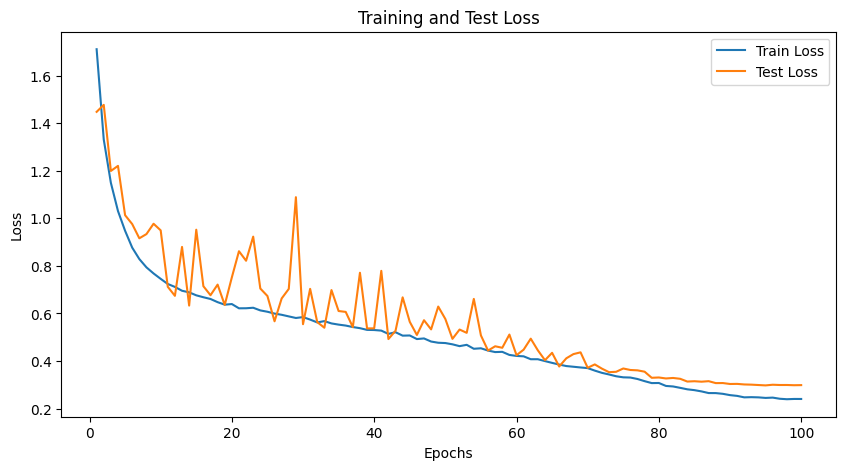

Final Test Accuracy: 90.72%


In [73]:
deepresnet = DeepResidualConvNetwork(input_size=(3, 32, 32), device=device)
deepresnet, deepres_train_losses, deepres_test_losses = train_model(deepresnet, cifar_train_loader, cifar_test_loader, num_epochs=100, lr=0.003, decay=1e-3, plot=True, device=device,
                                                                   save_checkpoint_path="checkpoints/deepresnet_ckpt.pth")
final_deepres_test_accuracy = test_model(deepresnet, cifar_test_loader, device=device)
print(f"Final Test Accuracy: {final_deepres_test_accuracy:.2f}%")